## Imports

In [131]:
% reset
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import os
import nltk
import re
import gensim
from sklearn.model_selection import train_test_split
from helpers import *
from cleaners import *
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import pathlib
from multiprocessing import Process
from pathlib import Path
from gensim.models import Word2Vec,TfidfModel,Phrases
from gensim.corpora import Dictionary
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier, Lasso
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import inspect
import itertools
from threading import Thread,Lock



%load_ext autoreload
%autoreload 2

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Some helpers used to convert docs to vecs using tf weighted word2vec averaging

In [10]:
# an iterator used by gensim to train models without loading the whole corpus in memory
class MyDocs(object):
    def __init__(self, dirname):
        self.dirname = dirname
 
    def __iter__(self):
        pathlist = Path(self.dirname).glob('**/*')
        for path in pathlist:
            path_in_str = str(path)
            if os.path.isfile(path_in_str):
                f=open(path_in_str)
                yield f.read().split()

In [11]:
def word2vec(docs_root,model_name=None):
    # Training a word2vec model, the bigram transformer tells gensim to create vectors for bigram phrases such New York
    save = model_name!=None
    model_path = f'models/wv_{model_name}'
    model_exists = os.path.isfile(model_path)
    dir_exists = os.path.isdir('models')

    wv_model = None
    
    if model_exists:
        wv_model = Word2Vec.load(model_path)
    else:
        docs = MyDocs(docs_root)
        wv_model = Word2Vec(docs, size=300, window=5, min_count=100, workers=6)
    
    if save:
        if not dir_exists:
            pathlib.Path.mkdir('models')
        if not model_exists:
            wv_model.save(model_path)

    return wv_model
    

In [12]:
def tf_idf_model(doc_path,model_name=None):
    model_path = f'models/tf_{model_name}'
    dict_path = f'models/dict_{model_name}'
    model_exists = os.path.isfile(model_path)
    dict_exists = os.path.isfile(dict_path)
    dir_exists = os.path.isdir('models')
    save = model_name!=None
    
    docs = MyDocs(doc_path)
    bow_dict = Dictionary.load(dict_path) if dict_exists else Dictionary(docs)
    corpus = [bow_dict.doc2bow(doc) for doc in docs]
    tf_model = TfidfModel.load(model_path) if model_exists else TfidfModel(corpus)
    if save:
        if not dir_exists:
            pathlib.Path.mkdir('models')
        if not model_exists:
            tf_model.save(model_path)
        if not dict_exists:
            bow_dict.save(dict_path)
    return corpus,bow_dict,tf_model
        

In [13]:
def tf_doc2vec_factory(bow_dict,tf_model,word2vec):
    def tf_doc2vec(doc_bow,raw_doc):
        tf_dict = {e0:e1 for e0,e1 in tf_model[doc_bow]}
        doc_tf_idf = np.array([tf_dict[tok_id] for tok_id in (bow_dict.token2id[tok] for tok in raw_doc if tok in word2vec.wv.vocab)])
        vecs = np.array([word2vec.wv[word] for idx,word in enumerate(raw_doc) if word in word2vec.wv.vocab])
        doc_vec = np.sum(doc_tf_idf.reshape(-1,1)*vecs,axis=0)
        return doc_vec
    return tf_doc2vec


In [14]:
def tf_wv_samples(model_prefix,root_dir,wv=None):
    # root dir is assumed to have children /pos and /neg
    # word 2 vec model is created using all descendents of the parent of root_dir
    # returns X,y 
    
    pos_dir = f'{root_dir}/pos'
    neg_dir = f'{root_dir}/neg'
    
    # get the word2vec model
    if wv is None:
        wv = word2vec(root_dir.split('/')[0],model_prefix)
        
    # get tf-idf models
    pos_corpus, pos_dict, pos_tf_model = tf_idf_model(pos_dir, f'{model_prefix}_pos')
    neg_corpus, neg_dict, neg_tf_model = tf_idf_model(neg_dir, f'{model_prefix}_neg')
    # get tf-doc2vec factories
    pos_tf_doc2vec = tf_doc2vec_factory(pos_dict, pos_tf_model, wv)
    neg_tf_doc2vec = tf_doc2vec_factory(neg_dict, neg_tf_model, wv)
    
    pos_vecs = []
    for bows,doc in zip(pos_corpus,MyDocs(pos_dir)):
        pos_vecs.append(pos_tf_doc2vec(bows,doc))
    pos_vecs = np.array(pos_vecs)
    
    neg_vecs = []
    for bows,doc in zip(neg_corpus,MyDocs(neg_dir)):
        neg_vecs.append(neg_tf_doc2vec(bows,doc))
    neg_vecs = np.array(neg_vecs)
    
    X = np.concatenate((pos_vecs,neg_vecs),axis=0)
    y = np.asarray([1]*pos_vecs.shape[0] + [-1]*pos_vecs.shape[0])
    
    return X, y, wv


In [15]:
def validate_svm(X, y, C):
    '''
       C: weight to the slack of the svm
       returns:
           best_svm: svm with the best accuracy
           clf_accs: accurcies of classifiers
           clf_vars: variance of k folds per classifier setting
    '''
    best_svm = None
    best_acc = 0
    clf_vars = []
    clf_accs = []
    for c in C:
        svm_clf = SVC(C=c) 
        accs = cross_val_score(svm_clf, X, y, n_jobs=-1)
        mean_acc, var_acc = np.mean(accs), np.var(accs)
        clf_accs.append(mean_acc)
        clf_vars.append(var_acc)
        if mean_acc > best_acc:
            best_acc = mean_acc
            best_svm = svm_clf
    return best_svm, clf_accs, clf_vars


In [16]:
def validate_random_forest(X, y, n_estimators):
    '''
       n_estimators: number of classifiers to try 
       
       returns:
           best_forest: svm with the best accuracy
           clf_accs: accurcies of classifiers
           clf_vars: variance of k folds per classifier setting
    '''
    best_forest = None
    best_acc = 0
    clf_vars = []
    clf_accs = []
    for n in n_estimators:
        forest_clf = RandomForestClassifier(n_estimators=n, n_jobs=-1)
        accs = cross_val_score(forest_clf, X, y, n_jobs=-1)
        mean_acc, var_acc = np.mean(accs), np.var(accs)
        clf_accs.append(mean_acc)
        clf_vars.append(var_acc)
        if mean_acc > best_acc:
            best_acc = mean_acc
            best_forest = svm_clf
    return best_forest, clf_accs, clf_vars

In [137]:
def cross_validate(X, y, classifier, parameters={},folds=None):
    
    n_samples = y.shape[0]
    perm_idx = np.random.permutation(n_samples)
    X_perm = X[perm_idx]
    y_perm = y[perm_idx]
    
    best_clf = None
    best_acc = 0
    clf_vars = []
    clf_mean_accs = []
    parameters_list = [{item[0]:item[1] for item in sublist} for 
                      sublist in itertools.product(*[[(key,val) for val in parameters[key]] 
                                                     for key in parameters.keys()])]
    
    
    for parameter_comb in parameters_list:
        clf = classifier(**parameter_comb)
        accs = cross_val_score(clf, X_perm, y_perm, n_jobs=-1,cv=folds)
        mean_acc, var_acc = np.mean(accs), np.var(accs)
        clf_mean_accs.append(mean_acc)
        clf_vars.append(var_acc)
        if mean_acc > best_acc:
            best_acc = mean_acc
            best_clf = clf
        print(f'trained {clf}')
    
    return best_clf, clf_mean_accs, clf_vars

## cleaning the data without POS tagging

###  cleaning train and test data

In [18]:
basic_cleaned_root = speedy(basic_cleaner, ['aclImdb/train/pos','aclImdb/train/neg'],10,target_suffix='clean')

### creating training and validation set

In [19]:
X,y,wv_basic = tf_wv_samples(model_prefix='basic', root_dir=f'{basic_cleaned_root}/train')
# X_train,X_val,y_train,y_val = train_test_split(X, y, test_size=0.33, random_state=42)

### validation of the classifiers

#### Hyper parameter tuning of logistic regression

In [125]:
C = [0.1,5,10,15,20]
best_lr, lr_accs, lr_vars = cross_validate(X,y,classifier=LogisticRegression,parameters={'C':C,'solver':['lbfgs']},folds=10)

trained LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)
trained LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)
trained LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)
trained LogisticRegression(C=15, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=N

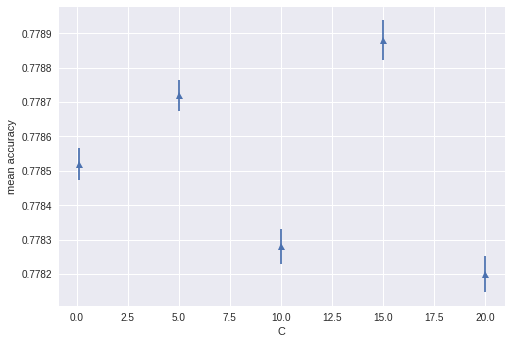

In [127]:
plt.errorbar(C, lr_accs, lr_vars, linestyle='None', marker='^')
plt.xlabel('C')
plt.ylabel('mean accuracy')
plt.show()

#### Hyper parameter tuning of RadnomForest

In [128]:
n_estimators = [50,100,200,300]
best_rf, rf_accs, rf_vars = cross_validate(X,y,classifier=RandomForestClassifier,parameters={'n_estimators':n_estimators,'max_depth':[5], 'n_jobs':[-1]},folds=10)

trained RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
trained RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
trained RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=

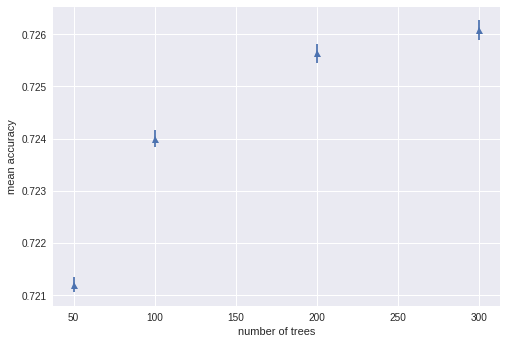

In [130]:
plt.errorbar(n_estimators, rf_accs, rf_vars, linestyle='None', marker='^')
plt.xlabel('number of trees')
plt.ylabel('mean accuracy')
plt.show()

In [144]:
best_nb, nb_accs, nb_vars = cross_validate(X,y,classifier=GaussianNB,folds=10)

trained GaussianNB(priors=None)


### Accuracy on the test data

In [37]:
basic_cleaned_test = speedy(basic_cleaner,['aclImdb/test/pos','aclImdb/test/neg'],10,target_suffix='clean')

In [41]:
X_test,y_test,wv_basic = tf_wv_samples(model_prefix='basic_nltk_2', root_dir=f'{basic_cleaned_test}/test',wv=wv_basic)


In [42]:
np.mean(clf.predict(X_test) == y_test)

0.73760000000000003

## POS tagged documents

In [27]:
pos_cleaned_root = speedy(pos_cleaner, ['aclImdb/train/pos','aclImdb/train/neg','aclImdb/train/unsup'],15,target_suffix='pos')

In [28]:
X,y,wv_pos = tf_wv_samples(model_prefix='pos', root_dir=f'{pos_cleaned_root}/train')
X_train,X_val,y_train,y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [67]:
clf = SVC(C=1)
clf.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [68]:
np.mean(clf.predict(X_val) == y_val)

0.78181818181818186

In [ ]:
basic_cleaned_test = speedy(basic_cleaner,['aclImdb/test/pos','aclImdb/test/neg'],10,target_suffix='clean_nltkTok_2')

## Google pre-trained word2vecs

In [10]:
model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)  
basic_cleaned_root = speedy(basic_cleaner, ['aclImdb/train/pos','aclImdb/train/neg','aclImdb/train/unsup'],15,target_suffix='clean')
X,y = tf_wv_samples(model_prefix='google', root_dir=f'{basic_cleaned_root}/train')
X_train,X_val,y_train,y_val = train_test_split(X, y, test_size=0.33, random_state=42)

/home/alyswidan/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [11]:
clf = SVC(C=1)
clf.fit(X_train, y_train)
np.mean(clf.predict(X_val) == y_val)

0.7781818181818182

In [136]:
def x(**kwargs):
    for i in kwargs:
        print(i)
x(**{})